# Neural & Behavioral Modeling - Week 11 (Exercises)
by 林子堯 (r08227112@ntu.edu.tw)

In [1]:
# Upgrade PyTorch if necessary:
! conda install -y pytorch-cpu torchvision-cpu -c pytorch

In [3]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

In [4]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
if(t.cuda.is_available()):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
else:
    print('No GPU')

PyTorch version: 1.6.0
No GPU


## 1 Tuning the performance of a neural net (10 points)

### 1.1 Problem
In the section 4.1 of 11_examples.ipynb, the neural network implemented in NumPy with two hidden layers could reach 90% classification accuracy on the MNIST training data only within 3 learning epochs:

<pre>
model=MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100], output_size=10,
                          weight_init_std=weight_init_std, use_batchnorm=True, use_dropout=True)
</pre>

However, in the section 4.2, a similar network implemented in PyTorch did not reached 90% clasification accuracy model on the MNIST training data: 

<pre>
model = t.nn.Sequential(
    t.nn.Linear(D_in, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    t.nn.Linear(H, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    t.nn.Linear(H, D_out),
    t.nn.Softmax()
)
</pre>

Your goal is to do whatever you can to help the PyTorch net reach 90% classification accuracy on the MNIST training data within 50 or less epochs.

### 1.2 Tips

First try to eliminate the differences between the NumPy net and the PyTorch net:

(1) The PyTorch version did not use 50% Dropout.

(2) The PyTorch used Adam with a learning rate of 1e-4 as an optimizer instead of SGD with a learning rate of 1e-2.

(3) The PyTroch version did not use shuffled batch (100 samples) in each training epoch.

(4) The NumPy version used He initialization on NORMAL W and ZEROED b:
<pre>
    def __init_weight(self, weight_init_std):

        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                <font color="red">scale = np.sqrt(2.0 / all_size_list[idx - 1])  # for ReLu</font>
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # for Sigmoid
            <font color="blue">self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])</font>
</pre>

However, the PyTroch version used Xavier initialization on UNIFORM W and b for <a href="https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L44-L48">linear layers</a>:

<pre>
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        <font color="red">self.reset_parameters()</font>
<font color="blue">
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
</font>
</pre>

(5)If removal of the above differences does not help, look for other differences or do whatever you can to accelerate learning of the PyTorch net.

<b>(6) Do not waste your time on checking out training results after 50 epochs! They have nothing to do with your goal here.</b>

### 1.3 Your codes and discussions

#### 1.3.1 The MNIST dataset

In [1]:
# Download the dataset:
import urllib.request
urllib.request.urlretrieve('https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz','mnist.pkl.gz')

('mnist.pkl.gz', <http.client.HTTPMessage at 0x2e040230f88>)

(50000, 784) (50000,) (10000, 784) (10000,)
0.0 0.99609375 0 9


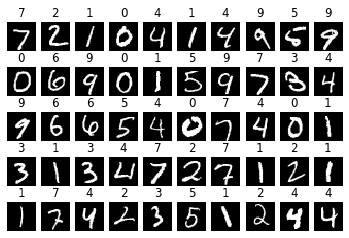

In [5]:
# Load the dataset:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
f.close()
x_train,y_train=train_set[0],train_set[1]
x_valid,y_valid=valid_set[0],valid_set[1]
x_test,y_test=test_set[0],test_set[1]

# Examine the dataset:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print(np.min(x_train),np.max(x_train),np.min(y_train),np.max(y_train))
for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(y_test[i]));
    axis('off')
    
# Transform NumPy arrays to PyTorch tensors:
use_cuda=t.cuda.is_available()

X_train=t.from_numpy(x_train)
Y_train=t.from_numpy(y_train)
X_test=t.from_numpy(x_test)
Y_test=t.from_numpy(y_test)

if(use_cuda):
    X_train=X_train.cuda()
    Y_train=Y_train.cuda()
    X_test=X_test.cuda()
    Y_test=Y_test.cuda()

#### 1.3.2 Your systematic explorations

In [6]:
# Here is the PyTorch net:

D_in,H,D_out=784,100,10

# Training the network:
model = t.nn.Sequential(
    t.nn.Linear(D_in, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    t.nn.Linear(H, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    t.nn.Linear(H, D_out),
    t.nn.Softmax()
)

loss_fn = t.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = t.optim.Adam(model.parameters(), lr=learning_rate) #https://pytorch.org/docs/stable/optim.html

if(use_cuda):
    model=model.cuda()
    loss_fn=loss_fn.cuda()
    
for i in range(51):
    # Forward pass:
    Y_pred = model(X_train)

    loss = loss_fn(Y_pred, Y_train)
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass:
    loss.backward()

    # Update the weights using gradient descent:
    optimizer.step()
    
    # Check training accuracy:
    if i % 10 == 0:
        Y_pred = model(X_train) # Y_pred.shape=[50000,10]
        Y_pred = t.max(Y_pred,1)[1] # Y_pred.shape=[50000]
        print('epoch ',i,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])

epoch  0 : 0.13846
epoch  10 : 0.4019
epoch  20 : 0.52164
epoch  30 : 0.59596
epoch  40 : 0.64488
epoch  50 : 0.68
